In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

222

***
## model training: finding number of iterations

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'drop_rate': 0.1,
    'max_drop': 20,
    'skip_drop': 0.66,

    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 55,
    'learning_rate': 0.05,
    'feature_fraction': 0.616,
    'bagging_fraction': 0.8,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'lambda_l1': 3.563444727371679,
    'lambda_l2': 0.30026771722107604,
    'bagging_freq': 0,
    'min_child_samples': 100,
    
    'seed': 19,
    'drop_seed': 19,
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2740634, number of used features: 300
[LightGBM] [Info] Start training from score -0.022338
[20]	valid_0's rmse: 0.899251	valid_0's pearsonr: 0.12374
[40]	valid_0's rmse: 0.897732	valid_0's pearsonr: 0.126344
[60]	valid_0's rmse: 0.897087	valid_0's pearsonr: 0.12743
[80]	valid_0's rmse: 0.896829	valid_0's pearsonr: 0.128837
[100]	valid_0's rmse: 0.897084	valid_0's pearsonr: 0.129187
[120]	valid_0's rmse: 0.896495	valid_0's pearsonr: 0.130686
[140]	valid_0's rmse: 0.896107	valid_0's pearsonr: 0.132204
[160]	valid_0's rmse: 0.895945	valid_0's pearsonr: 0.132525
[180]	valid_0's rmse: 0.895961	valid_0's pearsonr: 0.132642
[200]	valid_0's rmse: 0.895851	valid_0's pearsonr: 0.132751
[220]	valid_0's rmse: 0.895724	valid_0's pearsonr: 0.133578
[240]	valid_0's rmse: 0.895669	valid_0's pearsonr: 0.133807
[260]	valid_0's rmse: 0.895597	valid_0's pearsonr: 0.134681
[280]	valid_0's rmse: 0.895371	valid_0's 

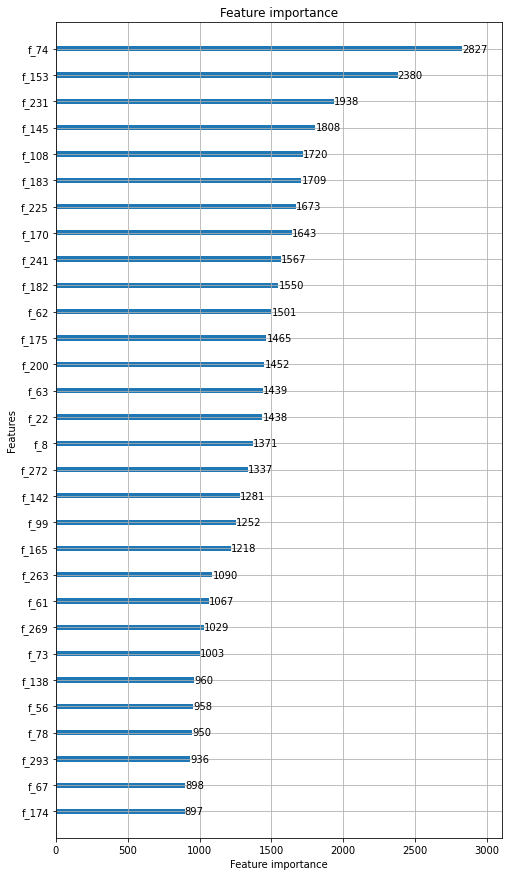

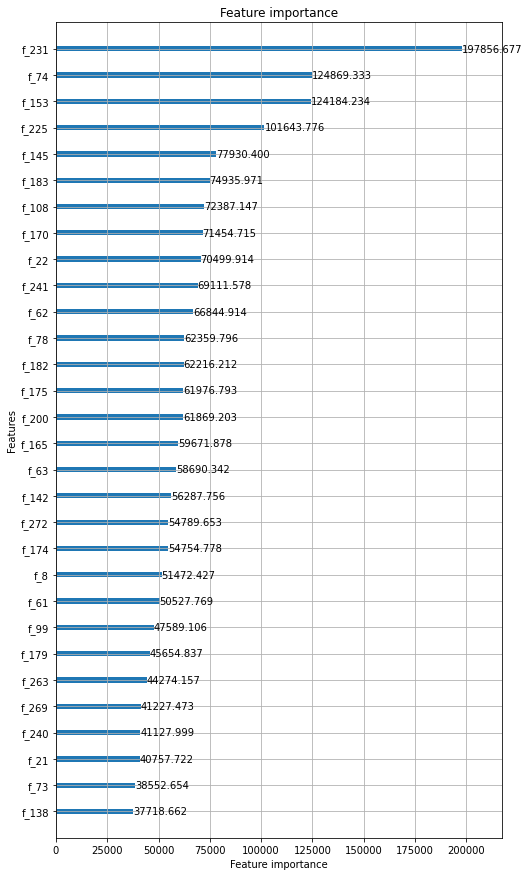

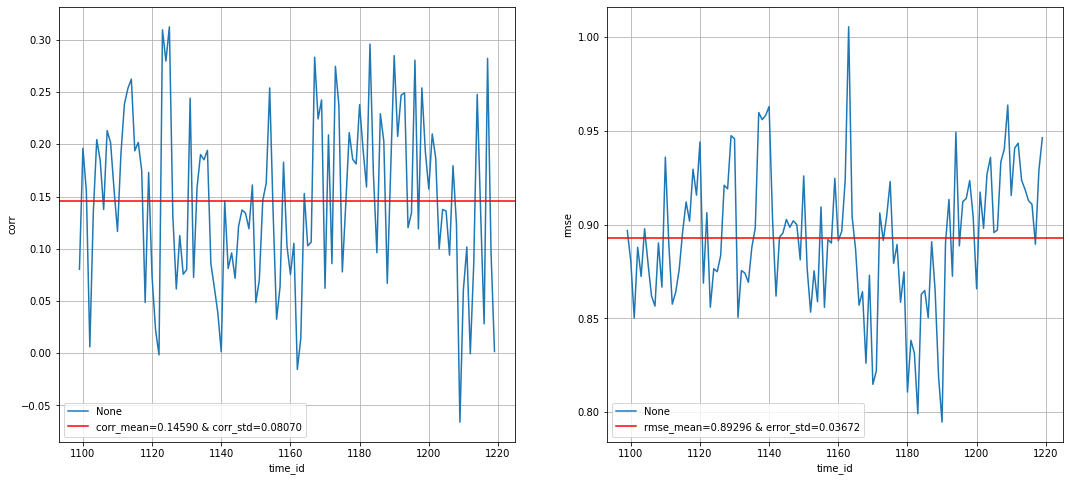

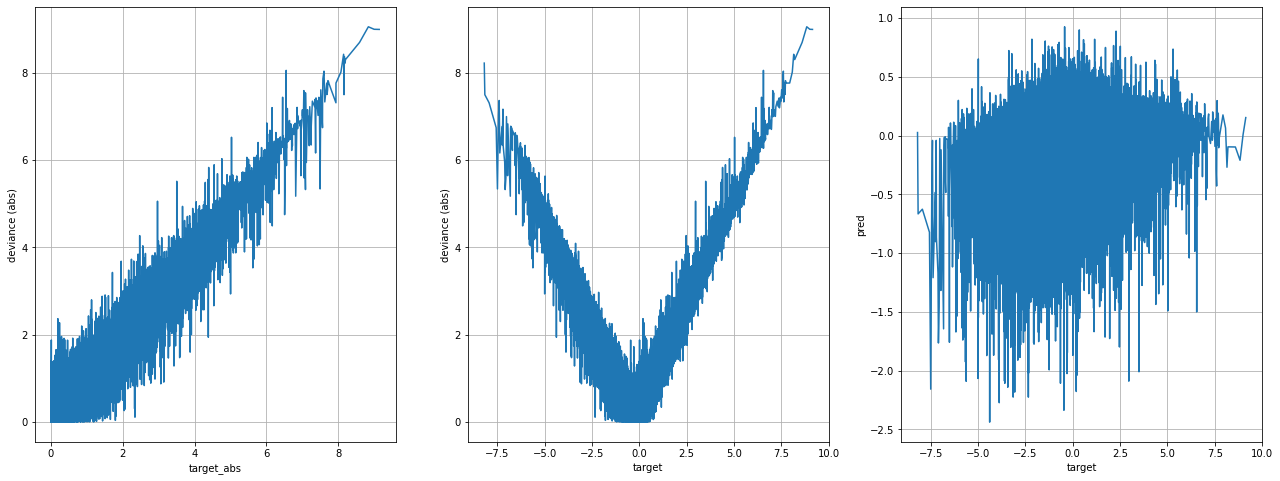

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2364296, number of used features: 300
[LightGBM] [Info] Start training from score -0.024609
[20]	valid_0's rmse: 0.907062	valid_0's pearsonr: 0.105595
[40]	valid_0's rmse: 0.905647	valid_0's pearsonr: 0.111669
[60]	valid_0's rmse: 0.904795	valid_0's pearsonr: 0.117474
[80]	valid_0's rmse: 0.904496	valid_0's pearsonr: 0.12029
[100]	valid_0's rmse: 0.904677	valid_0's pearsonr: 0.12097
[120]	valid_0's rmse: 0.904095	valid_0's pearsonr: 0.123434
[140]	valid_0's rmse: 0.903674	valid_0's pearsonr: 0.125668
[160]	valid_0's rmse: 0.9034	valid_0's pearsonr: 0.127292
[180]	valid_0's rmse: 0.903361	valid_0's pearsonr: 0.127723
[200]	valid_0's rmse: 0.903159	valid_0's pearsonr: 0.129086
[220]	valid_0's rmse: 0.903019	valid_0's pearsonr: 0.130515
[240]	valid_0's rmse: 0.902914	valid_0's pearsonr: 0.131343
[260]	valid_0's rmse: 0.902876	valid_0's pearsonr: 0.131916
[280]	valid_0's rmse: 0.902691	valid_0's pe

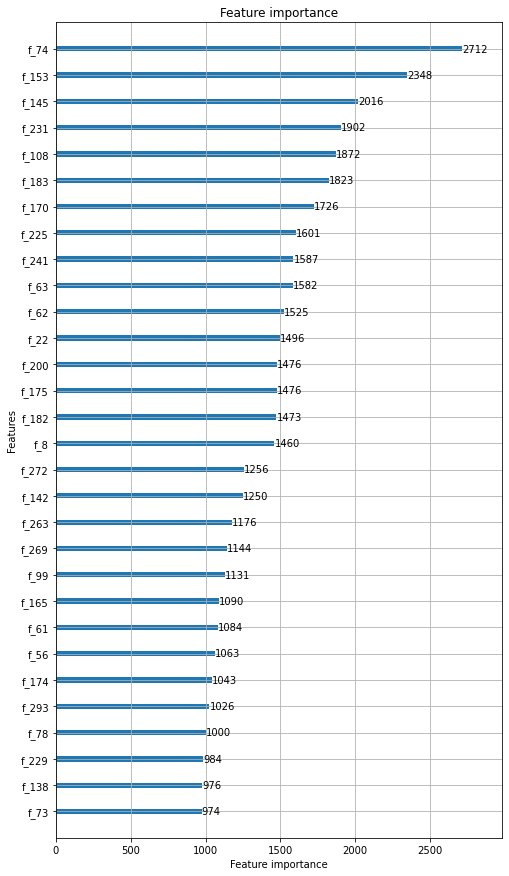

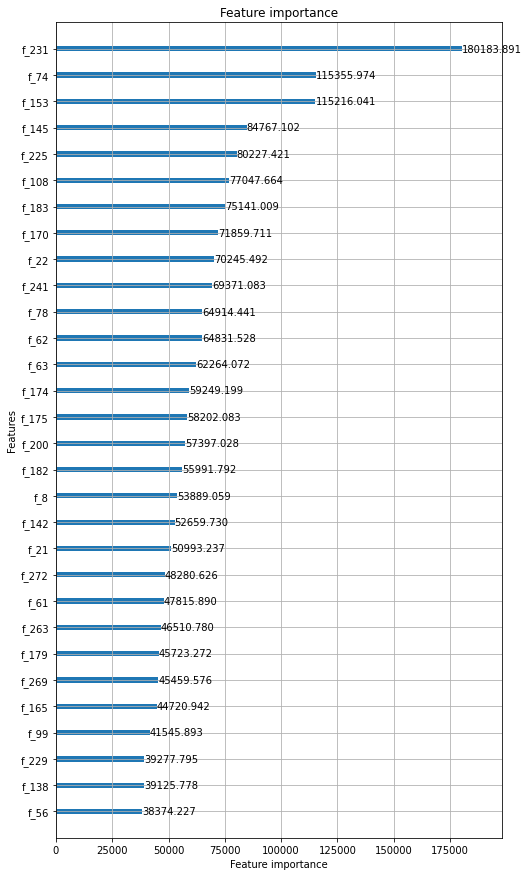

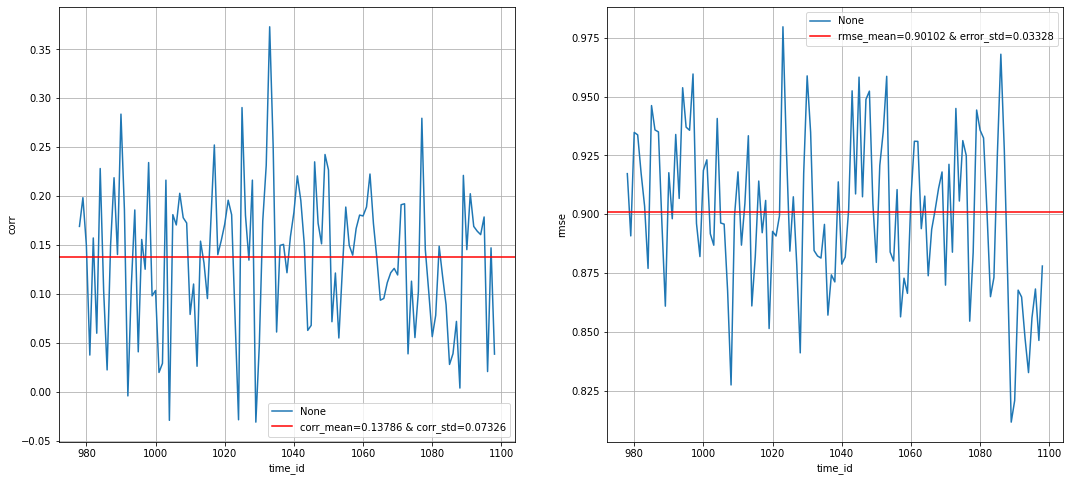

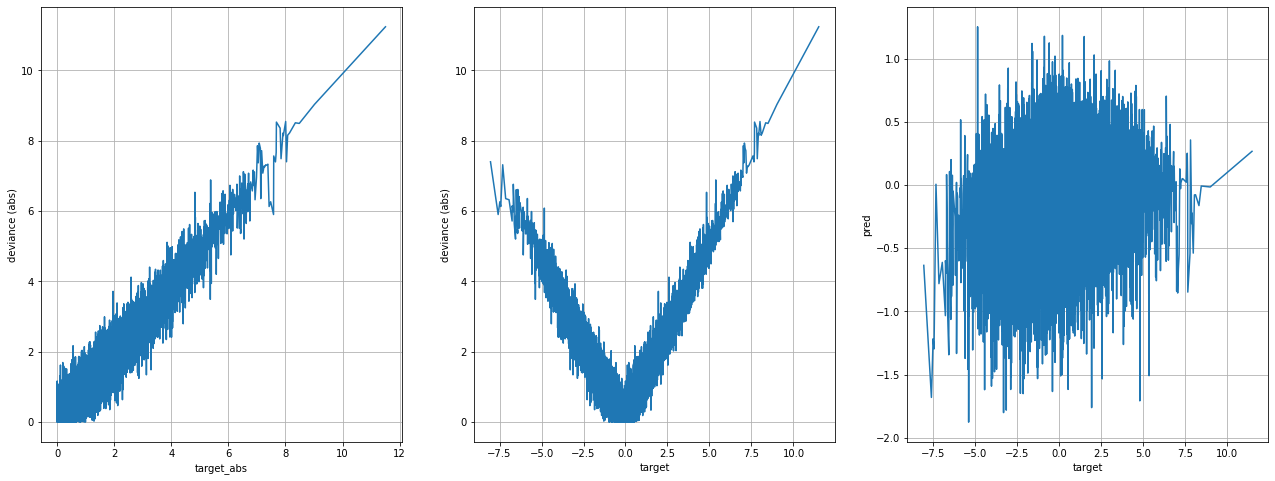

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1995404, number of used features: 300
[LightGBM] [Info] Start training from score -0.026871
[20]	valid_0's rmse: 0.941064	valid_0's pearsonr: 0.0926862
[40]	valid_0's rmse: 0.94	valid_0's pearsonr: 0.0975438
[60]	valid_0's rmse: 0.939262	valid_0's pearsonr: 0.103379
[80]	valid_0's rmse: 0.93899	valid_0's pearsonr: 0.106071
[100]	valid_0's rmse: 0.939099	valid_0's pearsonr: 0.106785
[120]	valid_0's rmse: 0.938765	valid_0's pearsonr: 0.107721
[140]	valid_0's rmse: 0.938482	valid_0's pearsonr: 0.109451
[160]	valid_0's rmse: 0.938242	valid_0's pearsonr: 0.111432
[180]	valid_0's rmse: 0.938081	valid_0's pearsonr: 0.113302
[200]	valid_0's rmse: 0.937902	valid_0's pearsonr: 0.114419
[220]	valid_0's rmse: 0.937768	valid_0's pearsonr: 0.115599
[240]	valid_0's rmse: 0.937667	valid_0's pearsonr: 0.116383
[260]	valid_0's rmse: 0.937584	valid_0's pearsonr: 0.117428
[280]	valid_0's rmse: 0.937381	valid_0's p

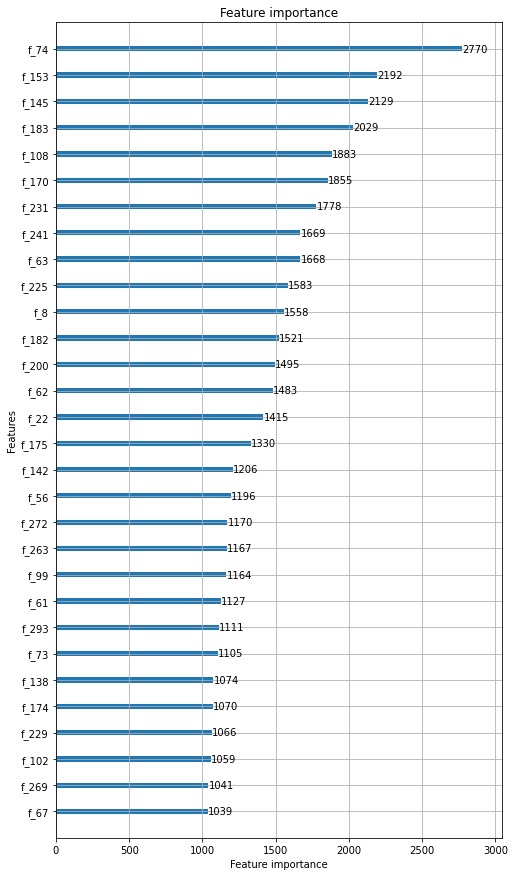

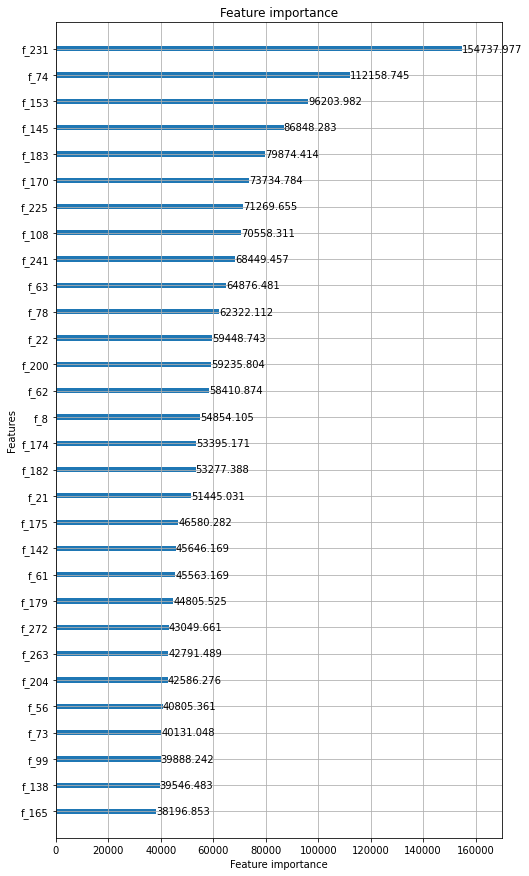

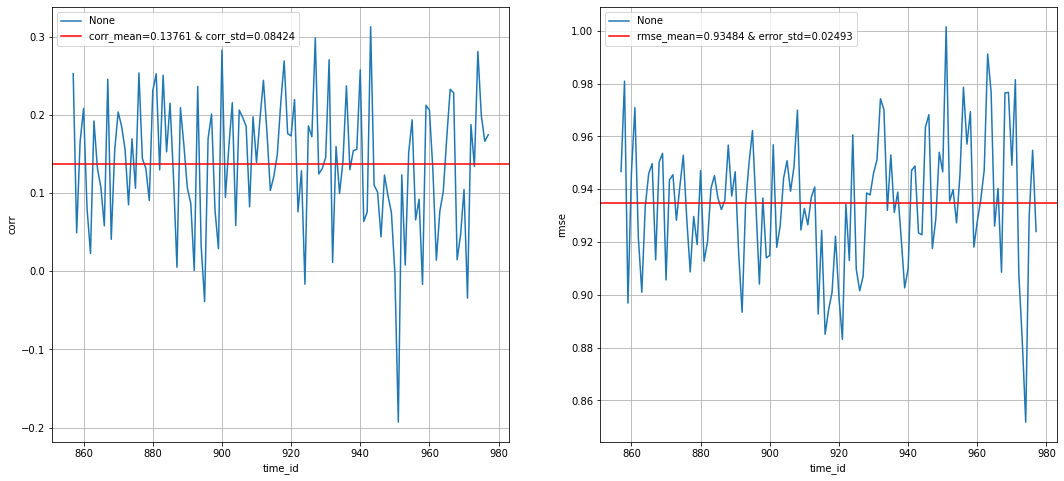

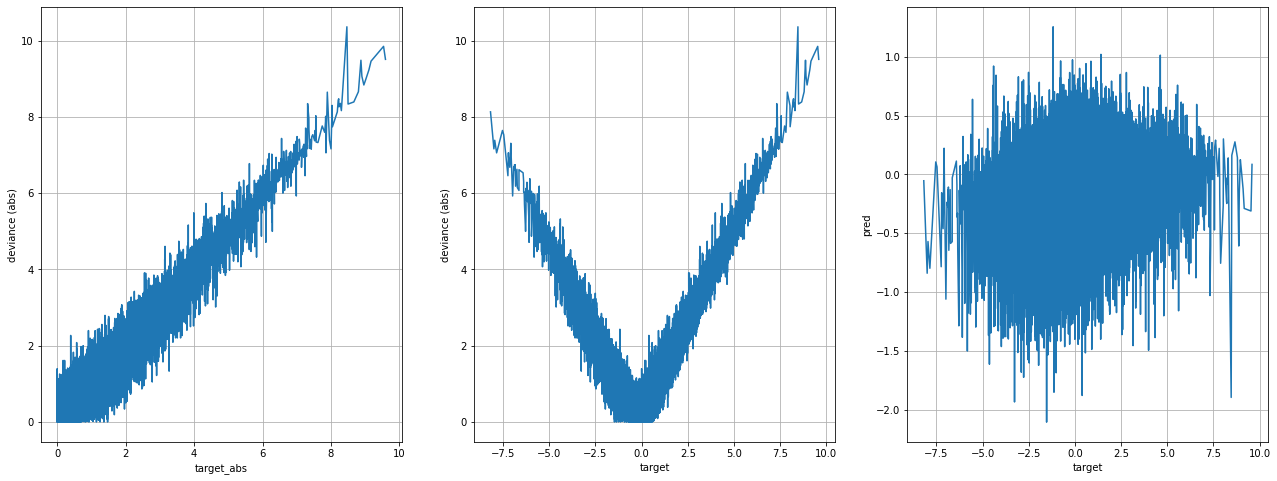

n_iterations: 0


In [10]:
pretrain = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if pretrain:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            num_boost_round=3000,
            valid_sets=[valid_dset,],
            #early_stopping_rounds=50,
            verbose_eval=20,
            feval=pearsonr,
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()
           
    n_iterations = int(np.mean([m.best_iteration for m in models]))
    
else:
    # best value previously found
    n_iterations = 546
    

print("n_iterations:", n_iterations)

In [11]:
metrics

{'corr_mean': [0.14589637251724197, 0.1378597436436202, 0.1376086737981256],
 'corr_std': [0.08069889087930937, 0.0732613299392743, 0.08423763522482704],
 'error_mean': [0.8929600433839121, 0.9010216824509922, 0.934836336791387],
 'error_std': [0.03671897153018543, 0.03328003559059705, 0.024929384951131374]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14045492998632925

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9096060208754304

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914217	training's pearsonr: 0.135946
[40]	training's rmse: 0.912828	training's pearsonr: 0.144356
[60]	training's rmse: 0.911831	training's pearsonr: 0.149774
[80]	training's rmse: 0.911017	training's pearsonr: 0.154981
[100]	training's rmse: 0.909895	training's pearsonr: 0.162065
[120]	training's rmse: 0.909444	training's pearsonr: 0.166606
[140]	training's rmse: 0.908603	training's pearsonr: 0.171759
[160]	training's rmse: 0.907787	training's pearsonr: 0.177493
[180]	training's rmse: 0.907399	training's pearsonr: 0.181351
[200]	training's rmse: 0.906852	training's pearsonr: 0.185439
[220]	training's rmse: 0.906145	training's pearsonr: 0.189967
[240]	training's rmse: 0.905629	training's pearsonr: 0.193895
[260]	training's rmse: 0.904868	training's pearsonr: 0.198453
[280]	trainin

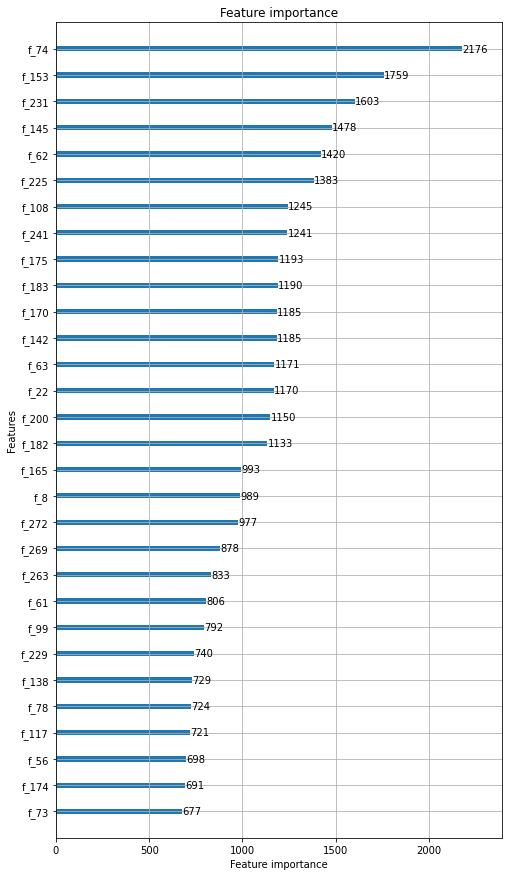

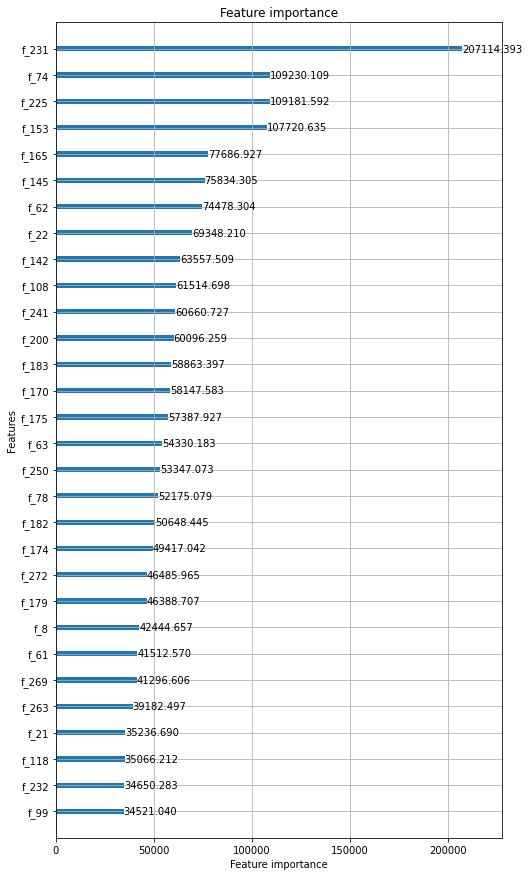

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914523	training's pearsonr: 0.136166
[40]	training's rmse: 0.912488	training's pearsonr: 0.144832
[60]	training's rmse: 0.911795	training's pearsonr: 0.15112
[80]	training's rmse: 0.910974	training's pearsonr: 0.155696
[100]	training's rmse: 0.910122	training's pearsonr: 0.161783
[120]	training's rmse: 0.909372	training's pearsonr: 0.166898
[140]	training's rmse: 0.908572	training's pearsonr: 0.172067
[160]	training's rmse: 0.907765	training's pearsonr: 0.17811
[180]	training's rmse: 0.907463	training's pearsonr: 0.181649
[200]	training's rmse: 0.906856	training's pearsonr: 0.185299
[220]	training's rmse: 0.906353	training's pearsonr: 0.189173
[240]	training's rmse: 0.905922	training's pearsonr: 0.192215
[260]	training's rmse: 0.905168	training's pearsonr: 0.197172
[280]	training'

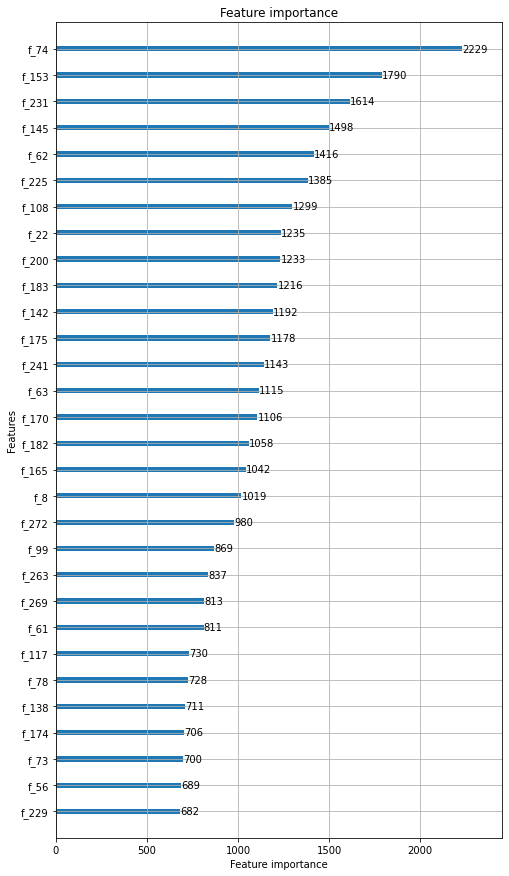

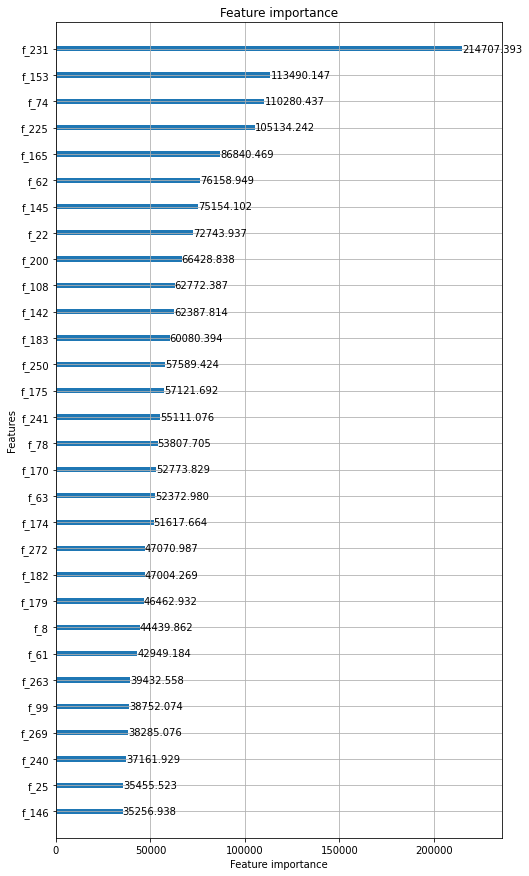

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.915251	training's pearsonr: 0.1332
[40]	training's rmse: 0.912886	training's pearsonr: 0.14229
[60]	training's rmse: 0.911314	training's pearsonr: 0.151301
[80]	training's rmse: 0.910239	training's pearsonr: 0.158936
[100]	training's rmse: 0.908975	training's pearsonr: 0.167761
[120]	training's rmse: 0.908869	training's pearsonr: 0.170908
[140]	training's rmse: 0.908224	training's pearsonr: 0.17574
[160]	training's rmse: 0.908061	training's pearsonr: 0.178127
[180]	training's rmse: 0.907256	training's pearsonr: 0.182755
[200]	training's rmse: 0.906094	training's pearsonr: 0.189287
[220]	training's rmse: 0.905511	training's pearsonr: 0.194339
[240]	training's rmse: 0.904797	training's pearsonr: 0.198588
[260]	training's rmse: 0.90457	training's pearsonr: 0.20182
[280]	training's rm

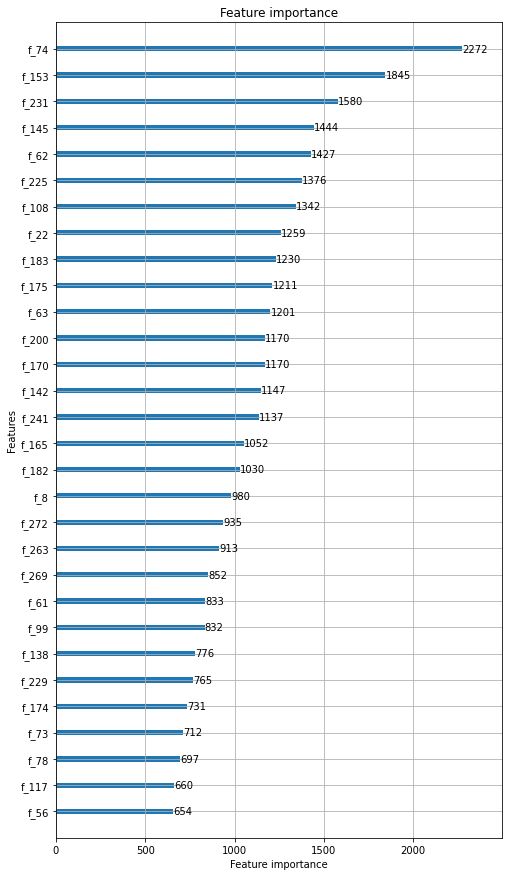

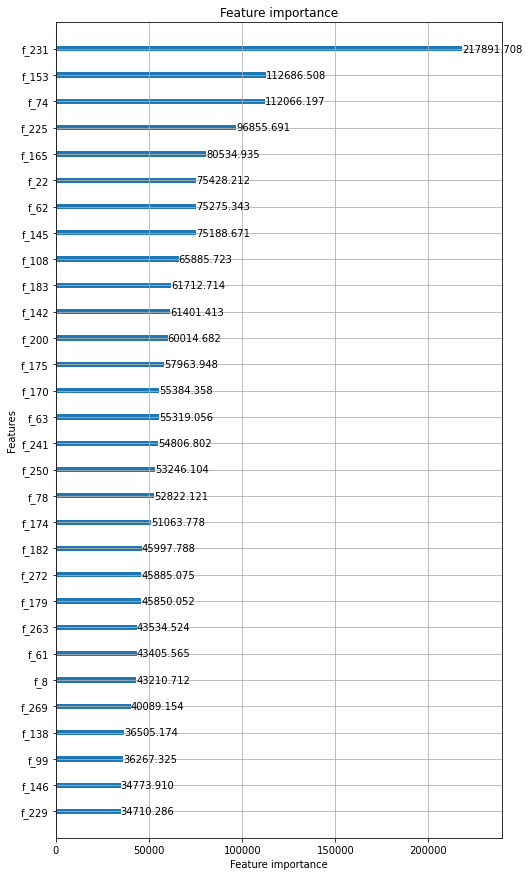

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.91486	training's pearsonr: 0.133235
[40]	training's rmse: 0.912466	training's pearsonr: 0.144676
[60]	training's rmse: 0.911043	training's pearsonr: 0.153544
[80]	training's rmse: 0.910238	training's pearsonr: 0.160157
[100]	training's rmse: 0.91052	training's pearsonr: 0.162044
[120]	training's rmse: 0.909267	training's pearsonr: 0.167972
[140]	training's rmse: 0.908078	training's pearsonr: 0.175068
[160]	training's rmse: 0.907131	training's pearsonr: 0.181486
[180]	training's rmse: 0.906765	training's pearsonr: 0.18574
[200]	training's rmse: 0.906035	training's pearsonr: 0.190197
[220]	training's rmse: 0.905567	training's pearsonr: 0.194039
[240]	training's rmse: 0.90502	training's pearsonr: 0.198331
[260]	training's rmse: 0.904805	training's pearsonr: 0.200541
[280]	training's 

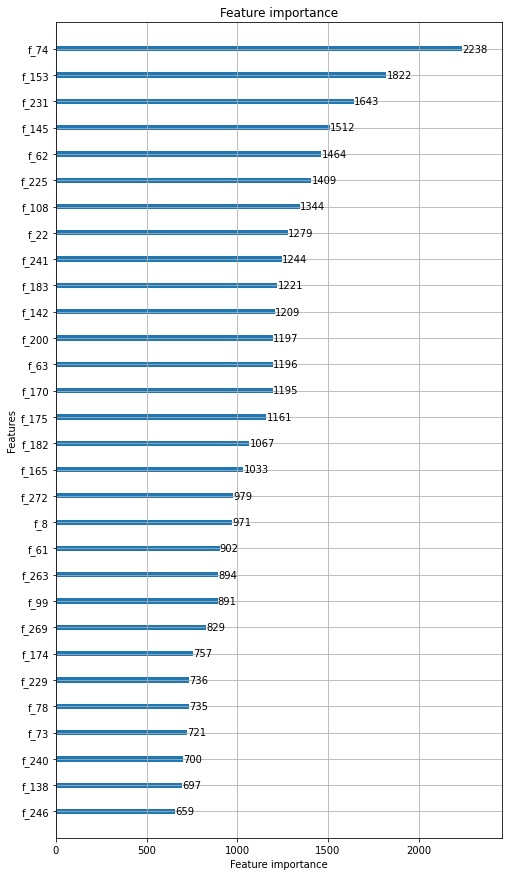

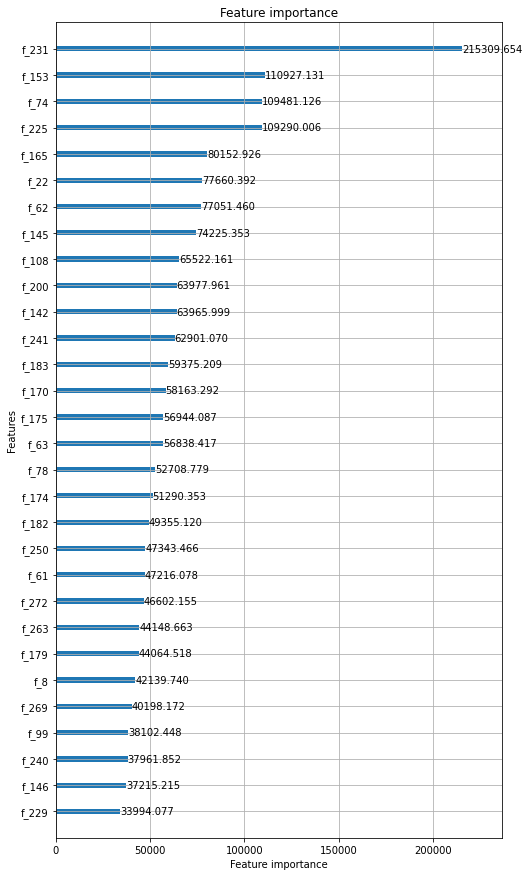

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3141410, number of used features: 300
[LightGBM] [Info] Start training from score -0.021092
[20]	training's rmse: 0.914527	training's pearsonr: 0.134532
[40]	training's rmse: 0.91282	training's pearsonr: 0.143952
[60]	training's rmse: 0.912057	training's pearsonr: 0.149819
[80]	training's rmse: 0.911059	training's pearsonr: 0.155892
[100]	training's rmse: 0.910476	training's pearsonr: 0.160253
[120]	training's rmse: 0.909284	training's pearsonr: 0.166567
[140]	training's rmse: 0.909401	training's pearsonr: 0.169346
[160]	training's rmse: 0.909067	training's pearsonr: 0.171594
[180]	training's rmse: 0.908541	training's pearsonr: 0.174473
[200]	training's rmse: 0.907959	training's pearsonr: 0.17836
[220]	training's rmse: 0.907199	training's pearsonr: 0.182754
[240]	training's rmse: 0.906577	training's pearsonr: 0.187256
[260]	training's rmse: 0.906057	training's pearsonr: 0.190938
[280]	training'

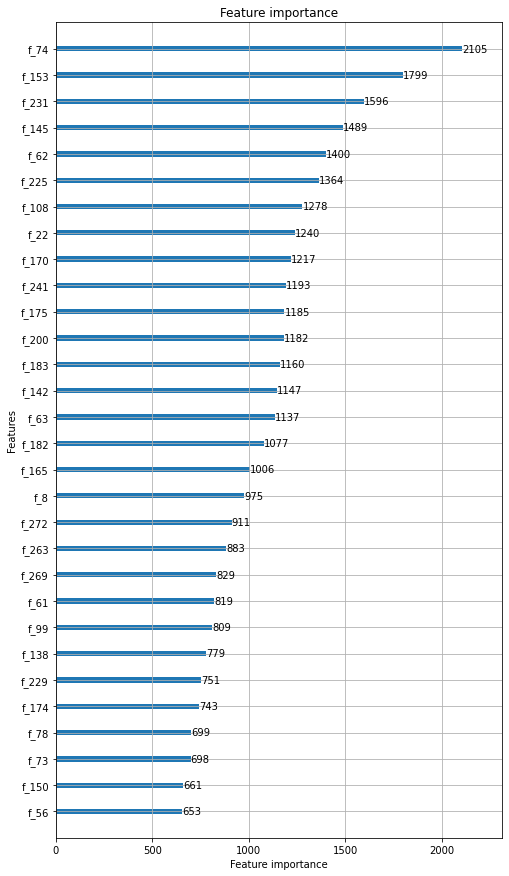

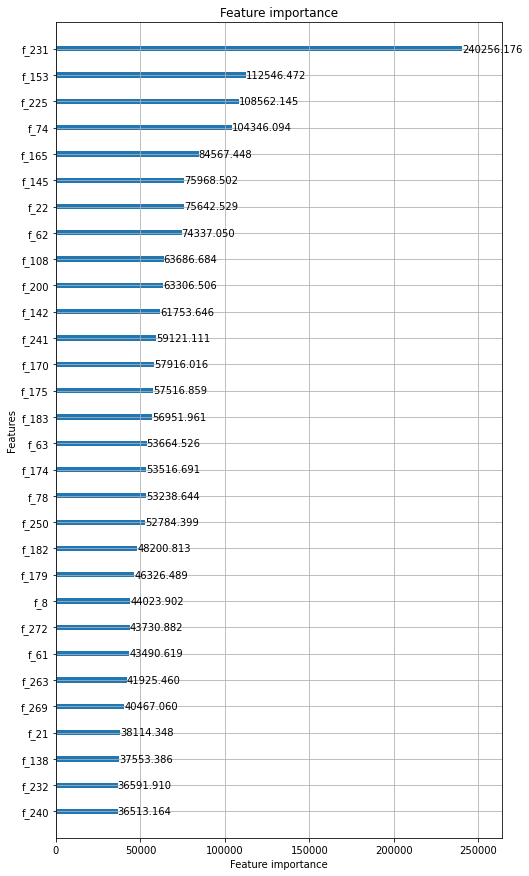

In [14]:
seeds = [2,7,11,19,23]
models = list()

for seed in seeds:
    model_params["seed"] = seed
    model_params["drop_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        num_boost_round=2200,
        valid_sets=[train_dset,],
        verbose_eval=20,
        feval=pearsonr,
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [19]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-dart/lgbm-seed{seed}.txt")

***
## inference

In [20]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***